In [33]:

import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import StratifiedKFold

In [2]:
df = pd.read_csv('/Users/joaosequeira/udacity_joao/atp_analysis/atp_tennis.csv')


In [3]:
df.head()

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,score
0,Brisbane International,2012-12-31,ATP250,Outdoor,Hard,1st Round,3,Mayer F.,Giraldo S.,Mayer F.,28,57,1215,778,1.36,3.00,6-4 6-4
1,Brisbane International,2012-12-31,ATP250,Outdoor,Hard,1st Round,3,Benneteau J.,Nieminen J.,Nieminen J.,35,41,1075,927,2.20,1.61,3-6 6-2 1-6
2,Brisbane International,2012-12-31,ATP250,Outdoor,Hard,1st Round,3,Nishikori K.,Matosevic M.,Nishikori K.,19,49,1830,845,1.25,3.75,7-5 6-2
3,Brisbane International,2012-12-31,ATP250,Outdoor,Hard,1st Round,3,Mitchell B.,Baghdatis M.,Baghdatis M.,326,36,137,1070,9.00,1.07,4-6 4-6
4,Brisbane International,2013-01-01,ATP250,Outdoor,Hard,1st Round,3,Istomin D.,Klizan M.,Istomin D.,43,30,897,1175,1.90,1.80,6-1 6-2


In [23]:
# Define uma função que retorna o vencedor de uma partida
def get_winner_rank(df):
    if df['Winner'] == df['Player_1']:
        return df['Rank_1']
    else:
        return df['Rank_2']
    
# Define uma função que retorna o perdedor de uma partida
def get_loser_rank(df):
    if df['Winner'] != df['Player_1']:
        return df['Rank_1']
    else:
        return df['Rank_2']
    
# Aplica a função ao DataFrame para criar a coluna "Loser"
df['Rank_loser'] = df.apply(get_loser_rank, axis=1)
df['Rank_winner'] = df.apply(get_winner_rank, axis=1)

df['Rank_dif'] = abs(df['Rank_1'] - df['Rank_2'])

df_treated = df[df['Rank_dif'] <= 200]


In [ ]:

# Definindo a quantidade de bins desejada
num_bins = 10

# Criando os bins
bins = pd.cut(df_treated['Rank_dif'], num_bins, labels=False)

# Criando dataframes com base nos bins
dataframes = []
for bin_id in range(num_bins):
    bin_df = df_treated[bins == bin_id]
    bin_df['Bin'] = bin_id
    dataframes.append(bin_df)

# Concatenando os dataframes
result = pd.concat(dataframes)

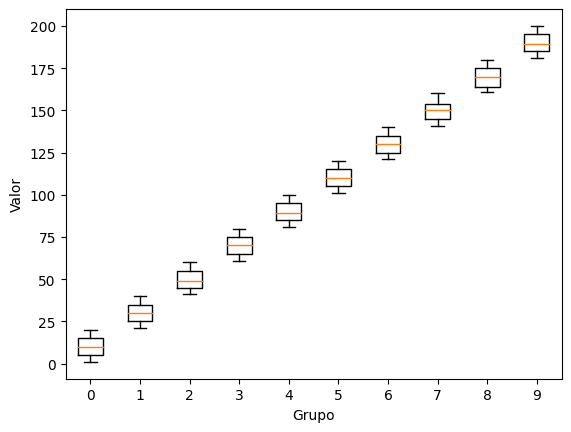

In [42]:

# Agrupando os valores por grupo
grouped_data = result.groupby('Bin')['Rank_dif'].apply(list)

# Criando o gráfico de boxplot
plt.boxplot(grouped_data)

# Definindo os rótulos dos eixos
plt.xlabel('Grupo')
plt.ylabel('Valor')

# Definindo os rótulos no eixo x
plt.xticks(range(1, len(grouped_data) + 1), grouped_data.index)

# Exibindo o gráfico
plt.show()

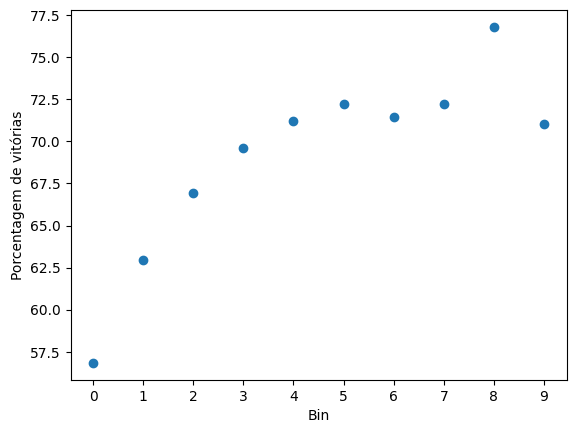

In [70]:
# Agrupando os dados por bin e calculando a porcentagem de vitória
grouped_data = result.groupby('Bin').apply(lambda x: (x['Rank_winner'] < x['Rank_loser']).mean() * 100)

# Criando o gráfico de pontos
plt.scatter(range(len(grouped_data)), grouped_data)

# Definindo os rótulos dos eixos
plt.xlabel('Bin')
plt.ylabel('Porcentagem de vitórias')

# Definindo os rótulos no eixo x
plt.xticks(range(len(grouped_data)), grouped_data.index)

# Exibindo o gráfico
plt.show()



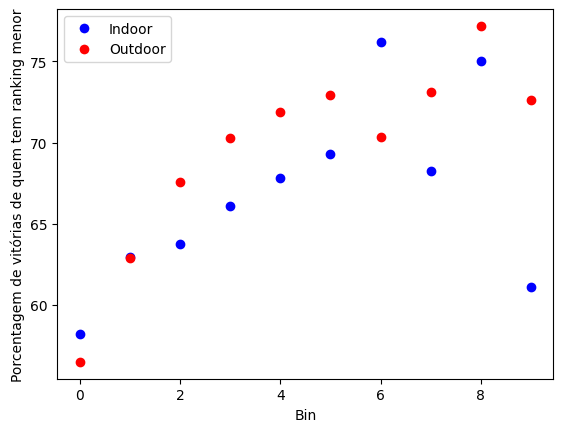

In [78]:
# Agrupando os valores por Bin e Court e calculando a porcentagem de vitórias
grouped_data = result.groupby(['Bin', 'Court']).apply(lambda x: (x['Rank_winner'] < x['Rank_loser']).mean() * 100)

# Criando o gráfico de pontos
fig, ax = plt.subplots()

# Definindo as cores para cada court
colors = {'Indoor': 'blue', 'Outdoor': 'red'}

# Iterando sobre os grupos e criando os pontos
for (bin_, court), percentage in grouped_data.items():
    ax.scatter(bin_, percentage, color=colors[court])

# Definindo os rótulos dos eixos
plt.xlabel('Bin')
plt.ylabel('Porcentagem de vitórias de quem tem ranking melhor')

# Criando a legenda com as cores dos courts
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Indoor',
                              markerfacecolor='blue', markersize=8),
                   plt.Line2D([0], [0], marker='o', color='w', label='Outdoor',
                              markerfacecolor='red', markersize=8)]
plt.legend(handles=legend_elements)

# Exibindo o gráfico
plt.show()



In [97]:
# Calculando a porcentagem de vitórias por bin e court
grouped_data = result.groupby(['Court', 'Bin']).apply(lambda x: (x['Rank_winner'] < x['Rank_loser']).mean() * 100)
grouped_data = grouped_data.reset_index(name='Porcentagem')

# Definindo as cores para cada court
colors = px.colors.qualitative.Plotly[:len(result['Court'].unique())]

# Criando o gráfico de pontos interativo com legenda
fig = px.scatter(grouped_data, x='Bin', y='Porcentagem', color='Court', symbol='Court',
                 color_discrete_sequence=colors, title='Porcentagem de vitórias por Bin e Court')
fig.update_layout(legend_title='Court', legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1))

fig.update_layout(width=600, height=400, plot_bgcolor='white')


# Exibindo o gráfico
fig.show()

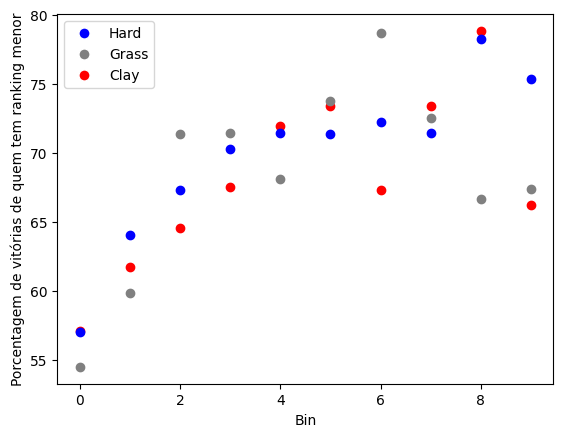

In [84]:
# Agrupando os valores por Bin e Court e calculando a porcentagem de vitórias
grouped_data = result.groupby(['Bin', 'Surface']).apply(lambda x: (x['Rank_winner'] < x['Rank_loser']).mean() * 100)

# Criando o gráfico de pontos
fig, ax = plt.subplots()

# Definindo as cores para cada court
colors = {'Hard': 'blue', 'Clay': 'red', 'Grass': 'gray'}

# Iterando sobre os grupos e criando os pontos
for (bin_, court), percentage in grouped_data.items():
    ax.scatter(bin_, percentage, color=colors[court])

# Definindo os rótulos dos eixos
plt.xlabel('Bin')
plt.ylabel('Porcentagem de vitórias de quem tem ranking menor')

# Criando a legenda com as cores dos courts
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Hard',
                              markerfacecolor='blue', markersize=8),
                   plt.Line2D([0], [0], marker='o', color='w', label='Grass',
                              markerfacecolor='gray', markersize=8),
                   plt.Line2D([0], [0], marker='o', color='w', label='Clay',
                              markerfacecolor='red', markersize=8)]
plt.legend(handles=legend_elements)

# Exibindo o gráfico
plt.show()



In [85]:
df['Round'].unique()

array(['1st Round', '2nd Round', 'Quarterfinals', 'Semifinals',
       'The Final', '3rd Round', '4th Round', 'Round Robin'], dtype=object)